# Sampling nuclear symmetry energy parameters

This notebook derives constraints on the nuclear symmetry energy parameters $(S_v,L)$ from chiral EFT calculations in pure neutron matter combined with empirical constraints on the nuclear saturation point.

The notebook is a minimalistic version of BUQEYE's [`derivatives-bands.ipynb`](https://github.com/buqeye/nuclear-matter-convergence/blob/master/analysis/derivatives-bands.ipynb) for this specific purpose.

## Installation

Navigate to the root directory of the `nuclear_saturation` repository and follow these instructions to install the code:

```shell
python3 -m venv env_esym  # in the root dir of this repository
source env_esym/bin/activate
python3 -m pip install -r requirements_esym.txt
python3 -m ipykernel install --name "nuclear-esym"
```

For completeness, we state the packages would need to be installed manually:
```shell
python3 -m pip install numpy
python3 -m pip install sympy
python3 -m pip install jupyter
python3 -m pip install corner
python3 -m pip install arviz
python3 -m pip install gsum
python3 -m pip install pymc3
python3 -m pip install statsmodels
python3 -m pip install docrep
python3 -m pip install findiff
python3 -m pip install seaborn
python3 -m pip uninstall gsum
python3 -m pip uninstall gptools
python3 -m pip install git+https://github.com/buqeye/gsum
python3 -m pip install Cython
python3 -m pip install git+https://github.com/markchil/gptools
python3 -m pip install tqdm
```

Clone BUQEYE's GitHub repository [nuclear-matter-convergence](https://github.com/buqeye/nuclear-matter-convergence) to your computer and tell your Python interpreter where to find it 

In [1]:
import sys
sys.path.append('/Users/drischler/Dropbox/Projects/nuclear-matter-convergence')

Now, you should be able to import the BUQEYE packages for EOS truncation error analysis and sampling:

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from scipy import stats
import pandas as pd
from nuclear_matter import fermi_momentum, nuclear_density, kf_derivative_wrt_density
from nuclear_matter import compute_pressure, compute_pressure_cov
from nuclear_matter import compute_slope, compute_slope_cov
from nuclear_matter import compute_compressibility, compute_compressibility_cov
from nuclear_matter import compute_speed_of_sound
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData
from nuclear_matter import confidence_ellipse, confidence_ellipse_mean_cov
from nuclear_matter.graphs import add_top_order_legend, compute_filled_handles, plot_empirical_saturation
from nuclear_matter.derivatives import ObservableContainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'gptools'

## Sampling

Marginalization:
$$
P(S_v,L) = \int dn_0 \, dE_0 \, P(S_v,L \mid n_0, E_0) \, P(n_0, E_0)
$$

In [ ]:
def sample_sv_l(num_sats=101, num_GP_samples=50, Lambda=500, posterior_predict_params=None, high_density=True):
    if Lambda not in (500, 450):
        raise ValueError(f"Requested Lambda {Lambda} not supported.")

    # high_density = True
    if high_density:
        filename = './data/all_matter_data_high_density.csv'
    else:
        filename = './data/all_matter_data.csv'
        
    data = InputData(filename, Lambda)
    density = data.density
    kf_n = data.kf_n
    density_all = np.arange(density[0], density[-1], 0.005)
    kf_n_all = fermi_momentum(density_all, degeneracy=2)
    y_n_2_plus_3bf = data.y_n_2_plus_3bf
    orders = np.array([0, 2, 3, 4])
    breakdown = 600 # MeV
    verbose = True
    kf0_n = fermi_momentum(0.16, 2)

    ref_neutron = 16 / kf0_n**2

    if Lambda == 500:
        std_neutron = 1.00
        ls_neutron = 0.973
    elif Lambda == 450:
        std_neutron = 0.8684060649936118
        ls_neutron = 0.7631421388401067
    min_uncertainty = 0.02  # Twenty keV
    uncertainty_factor = 0.001  # 0.1%
    err_y_n = np.abs(y_n_2_plus_3bf[:, -1]) * uncertainty_factor
    err_y_n[np.abs(err_y_n) < min_uncertainty] = min_uncertainty
    obs_neutron = ObservableContainer(
        density=density,
        kf=kf_n,
        y=y_n_2_plus_3bf,
        orders=orders,
        density_interp=density_all,
        kf_interp=kf_n_all,
        std=std_neutron,
        ls=ls_neutron,
        ref=ref_neutron,
        breakdown=breakdown,
        err_y=err_y_n,
        include_3bf=False,
        derivs=[0, 1, 2],
        verbose=verbose,
    )
    # emp_sat_point_dist = stats.multivariate_normal(
    #     mean=[0.17, -16.], 
    #     cov=np.diag([0.01**2, 0.1**2])
    # )

    if posterior_predict_params is None:
        dist_kwargs = dict(
            loc=[  0.16083667, -15.9292    ], 
            shape=np.array([[1.07708821e-05, 1.65382275e-04],
            [1.65382275e-04, 2.74842604e-02]]),
            df=17
        )
    else:
        dist_kwargs = dict(
            loc=posterior_predict_params["mu"], 
            shape=posterior_predict_params["Psi"],
            df=posterior_predict_params["nu"]
        )    
    emp_sat_point_dist = stats.multivariate_t(**dist_kwargs)

    np.random.seed(1)
    de_sats = emp_sat_point_dist.rvs(num_sats)
    d_sats = de_sats[:, 0]
    e_sats = de_sats[:, 1]
    kf_n_sats = fermi_momentum(d_sats, 2)
    Kf_n_sats = kf_n_sats[:, None]

    def compute_Esym_L(kf, n, e, S2_dS2, S2_dS2_cov):
        to_Esym_L_mat = np.array([
            [1, 0],
            [0, 3*n*kf_derivative_wrt_density(kf, n)]  # the derivative is w.r.t. to kf, not the density
        ])
        S2_L = to_Esym_L_mat @ S2_dS2 - np.array([e, 0])
        S2_L_cov = to_Esym_L_mat @ S2_dS2_cov @ to_Esym_L_mat.T
        return S2_L, S2_L_cov

    from tqdm import tqdm
    np.random.seed(1)
    df = []
    for index in tqdm(range(num_sats), desc="Sampling emp. sat. point"):
        E_dE, E_dE_cov = obs_neutron.predict(np.atleast_2d(Kf_n_sats[index]), order=4, derivs=[0, 1])
        E_L_mean, E_L_cov = compute_Esym_L(kf=kf_n_sats[index], n=d_sats[index], e=e_sats[index],
                                        S2_dS2=E_dE, S2_dS2_cov=E_dE_cov)
        # note that the derivative is w.r.t. kf, not the density
        sample = stats.multivariate_normal.rvs(mean=E_L_mean, cov=E_L_cov, size=num_GP_samples)
        df.append(pd.DataFrame(np.atleast_2d(sample), columns=("Sv", "L")))
    return pd.concat(df)

## Test evaluations to investigate the runtime

Let's run a few test calculations. 

In [ ]:
nsat, esat = 0.16, -16
dist_kwargs = dict(
            mu=[  nsat, esat    ], 
            Psi=np.eye(2)*0.000001,
            nu=160000  # normal
        )

dat = sample_sv_l(num_sats=101000, num_GP_samples = 500, Lambda=500, posterior_predict_params=dist_kwargs)
print("sample mean", dat.mean())
print("sample std", np.sqrt(dat.cov()))
print("expected Sv", np.array([16.362972180704700 + esat, 0.9868380045082120]))  # Sv (data from BUQEYE)
print("expect L", np.array([2.8978682916931900, 0.4041150279261480]) * 3 / nsat)  # Slope parameter (mean, std)

For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 101000/101000 [13:42<00:00, 122.84it/s]


sample mean Sv    32.362836
L     54.334244
dtype: float64
sample std          Sv         L
Sv  0.99343  2.705990
L   2.70599  7.608165
expected Sv [0.36297218 0.986838  ]
expect L [54.33503047  7.57715677]


In [ ]:
dist_kwargs = dict(
            mu=[  0.160 , -15.96    ], 
            Psi=np.array([[0.002**2 , -0.012**2],
            [-0.012**2, 0.12**2]]),
            nu=16
        )

dat = sample_sv_l(num_sats=101000, num_GP_samples = 500, Lambda=500, posterior_predict_params=dist_kwargs)
print(dat.mean())
print(np.sqrt(dat.cov()))

For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 101000/101000 [13:35<00:00, 123.81it/s]


Sv    32.326183
L     54.351790
dtype: float64
          Sv         L
Sv  1.043155  2.778366
L   2.778366  7.721239


In [ ]:
sample_sv_l(num_sats=101, num_GP_samples = 50000, Lambda=500).mean()

For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point:  96%|█████████▌| 97/101 [00:01<00:00, 94.91it/s]


KeyboardInterrupt: 

In [ ]:
sample_sv_l(num_sats=1010, num_GP_samples = 50, Lambda=500).mean()

For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point:   4%|▎         | 36/1010 [00:00<00:08, 110.52it/s]


KeyboardInterrupt: 

In [ ]:
sample_sv_l(num_sats=1010, num_GP_samples = 500, Lambda=500).mean()

For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 1010/1010 [00:08<00:00, 123.21it/s]


Sv    32.397953
L     54.930678
dtype: float64

In [ ]:
sample_sv_l(num_sats=10100, num_GP_samples = 50, Lambda=500).mean()

For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10100/10100 [01:26<00:00, 116.34it/s]


Sv    32.386351
L     54.903259
dtype: float64

In [ ]:
sample_sv_l(num_sats=101000, num_GP_samples = 5, Lambda=500).mean()

For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 101000/101000 [13:21<00:00, 126.00it/s]


Sv    32.391370
L     54.920654
dtype: float64

In [ ]:
sample_sv_l(num_sats=101000, num_GP_samples = 50, Lambda=500).mean()

For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 101000/101000 [13:32<00:00, 124.32it/s]


Sv    32.392716
L     54.930372
dtype: float64

In [ ]:
sample_sv_l(num_sats=501000, num_GP_samples = 5, Lambda=500).mean()

For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 501000/501000 [1:20:43<00:00, 103.43it/s] 


Sv    32.391449
L     54.928074
dtype: float64

In [ ]:
sample_sv_l(num_sats=501000, num_GP_samples = 50, Lambda=500).mean()

For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 501000/501000 [1:42:47<00:00, 81.23it/s]     


Sv    32.391448
L     54.928149
dtype: float64

In [ ]:
sample_sv_l(num_sats=10100, num_GP_samples=50, Lambda=500).mean()

For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10100/10100 [01:21<00:00, 124.37it/s]


Sv    32.386351
L     54.903259
dtype: float64

## Test evaluation with corner plot

Pandas support in corner is deprecated; use ArviZ directly


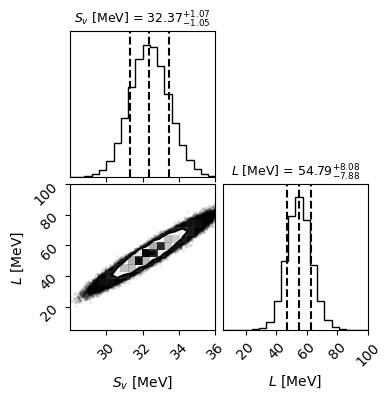

In [ ]:
import matplotlib.pyplot as plt
import arviz as az
import corner
df = sample_sv_l(num_sats=10100, num_GP_samples=50, Lambda=500)
fig, axes = plt.subplots(2, 2, figsize=(4, 4), constrained_layout=False)
fig = corner.corner(
    data=df,
    range=[(28, 36), (5, 100)],
    labels=[r'$S_v$ [MeV]', r'$L$ [MeV]'], 
    fig=fig,
    quantiles=(0.16, 0.5, 0.84),  # note that the median (=0.5) and mean may be (slightly different)
    levels=(1-np.exp(-0.5), 1-np.exp(-0.5*2**2)),
    show_titles=True, 
    title_kwargs={"fontsize": 9}
)
# filename = f"corner_lam_{Lambda}_num_sats_{num_sats}_num_GP_samples_{num_GP_samples}.pdf"
# fig.savefig(filename)
# df.to_csv(filename.replace(".pdf", ".csv").replace("corner", "samples"))

## Full run with data I/O

In [ ]:
import pickle
filename="/Users/drischler/GitHub/nuclear_saturation/samples/results_posteriors.pkl"
with open(filename, 'rb') as fp:
    res_postpred = pickle.load(fp)
    # print(res_postpred)

In [ ]:
from plot_helpers import confidence_ellipse, fit_bivariate_t
for Lambda in (500, 450):  # MeV
    ret = {}
    for prior_set_lbl, results in res_postpred.items():
        print("Working on prior:", prior_set_lbl)
        print("-"*50)
        ret_data = {}
        for res_lbl, post_pred in results.items():
            print("\twith data config:", res_lbl)
            samples = sample_sv_l(num_sats=10100, num_GP_samples=800, Lambda=Lambda, posterior_predict_params=post_pred)  # 101000
            fit = fit_bivariate_t(samples.to_numpy(), alpha_fit=0.68, nu_limits=None, tol=1e-2, print_status=False)
            ret_data[res_lbl] = {"satpoint_dist":results, "cov": samples.cov().to_numpy(), **fit}
            fit2 = fit_bivariate_t(samples.to_numpy(), alpha_fit=0.68, nu_limits=None, tol=1e-2, print_status=False, strategy="old")
            print("+"*30)
            print("fit new", fit)
            print("fit old", fit2)
            print("+"*30)
        ret[prior_set_lbl] = ret_data
    filename = f'./sv_l_samples_Lambda_{Lambda}.pkl'
    with open(filename, 'wb') as fp:
        pickle.dump(ret, fp)
        print(f"Results for Lambda {Lambda} MeV written to file '{filename}' for external processing")

Working on prior: Set A
--------------------------------------------------
	with data config: satbox
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10100/10100 [01:20<00:00, 125.10it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
fit new {'mu': [32.38655009487843, 54.905528258487315], 'Psi': array([[ 1.1304728 ,  8.14101676],
       [ 8.14101676, 63.75271028]]), 'nu': 134.0}
fit old {'mu': array([32.38726029, 54.91078852]), 'Psi': array([[ 1.14755754,  8.2640512 ],
       [ 8.2640512 , 64.71619913]]), 'nu': inf}
	with data config: satbox_wo_SQMC700
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10100/10100 [01:20<00:00, 125.38it/s]
